In [1]:
import urllib.request
import os

In [2]:
url="http://biostat.mc.vanderbilt.edu/wiki/pub/Main/DataSets/titanic3.xls"
filepath="data/titanic.xls"
if not os.path.isfile(filepath):
    result=urllib.request.urlretrieve(url,filepath)
    print('downloaded:',result)

In [3]:
import numpy as np
import pandas as pd
all_df = pd.read_excel(filepath)

In [4]:
all_df[:2]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


In [5]:
cols=['survived','name','pclass','sex','age','sibsp','parch','fare','embarked']
all_df = all_df[cols]

In [6]:
all_df[:2]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S


In [7]:
df=all_df.drop(['name'],axis=1)

In [8]:
all_df.isnull().sum()

survived      0
name          0
pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [9]:
#fill average number to where is nill
age_mean = df['age'].mean()
df['age'] = df['age'].fillna(age_mean)
fare_mean = df['fare'].mean()
df['fare'] = df['fare'].fillna(fare_mean)
#Map out female and male
df['sex'] = df['sex'].map({'female':0, 'male':1}).astype(int)

In [10]:
#Embark turn to OneHot
x_OneHot_df = pd.get_dummies(data=df,columns=['embarked'])
x_OneHot_df[:2]

,survived,pclass,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1,1,0,29.0000,0,0,211.3375,0,0,1
1,1,1,1,0.9167,1,2,151.5500,0,0,1


In [11]:
ndarray = x_OneHot_df.values
ndarray.shape

(1309, 10)

In [12]:
ndarray[:2]

array([[  1.    ,   1.    ,   0.    ,  29.    ,   0.    ,   0.    ,
        211.3375,   0.    ,   0.    ,   1.    ],
       [  1.    ,   1.    ,   1.    ,   0.9167,   1.    ,   2.    ,
        151.55  ,   0.    ,   0.    ,   1.    ]])

In [13]:
Label = ndarray[:,0]
Features = ndarray[:,1:]

In [14]:
print(Label[:2])
print(Features[:2])

[1. 1.]
[[  1.       0.      29.       0.       0.     211.3375   0.       0.
    1.    ]
 [  1.       1.       0.9167   1.       2.     151.55     0.       0.
    1.    ]]


In [15]:
from sklearn import preprocessing
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
scaledFeatures=minmax_scale.fit_transform(Features)
scaledFeatures[:2]

array([[0.        , 0.        , 0.36116884, 0.        , 0.        ,
        0.41250333, 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]])

In [16]:
msk = np.random.rand(len(all_df)) < 0.8
train_df = all_df[msk]
test_df = all_df[~msk]
print('total:',len(all_df),
      'train:',len(train_df),
      'test:',len(test_df))

total: 1309 train: 1044 test: 265


In [19]:
def PreprocessData(raw_df):
    df=all_df.drop(['name'],axis=1)
    age_mean = df['age'].mean()
    df['age'] = df['age'].fillna(age_mean)
    fare_mean = df['fare'].mean()
    df['fare'] = df['fare'].fillna(fare_mean)
    df['sex'] = df['sex'].map({'female':0,'male':1}).astype(int)
    x_OneHot_df = pd.get_dummies(data=df,columns=['embarked'])
    
    ndarray = x_OneHot_df.values
    Features = ndarray[:,1:]
    Label = ndarray[:,0]
    
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaledFeatures=minmax_scale.fit_transform(Features)
    
    return scaledFeatures,Label

In [20]:
train_Features, train_Label = PreprocessData(train_df)
test_Features, test_Label = PreprocessData(test_df)

In [21]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from keras.models import Sequential
from keras.layers import Dense,Dropout

Using TensorFlow backend.


In [23]:
model = Sequential()

#Hidden Layout 1
model.add(Dense(units=40,input_dim=9,
                kernel_initializer='uniform',
                activation='relu'))

#Hidden Layout 2
model.add(Dense(units=30,
                kernel_initializer='uniform',
                activation='relu'))

#Output Layout
model.add(Dense(units=1,
                kernel_initializer='uniform',
                activation='sigmoid'))

In [26]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                400       
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 1,661
Trainable params: 1,661
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])
train_history=model.fit(x=train_Features,
                        y=train_Label,
                        validation_split=0.1,
                        epochs=30,
                        batch_size=30,verbose=2)

Train on 1178 samples, validate on 131 samples
Epoch 1/30
 - 0s - loss: 0.6886 - acc: 0.5925 - val_loss: 0.6582 - val_acc: 0.7863
Epoch 2/30
 - 0s - loss: 0.6506 - acc: 0.6273 - val_loss: 0.5389 - val_acc: 0.7863
Epoch 3/30
 - 0s - loss: 0.5730 - acc: 0.7105 - val_loss: 0.4935 - val_acc: 0.8092
Epoch 4/30
 - 0s - loss: 0.5151 - acc: 0.7632 - val_loss: 0.4308 - val_acc: 0.8168
Epoch 5/30
 - 0s - loss: 0.4922 - acc: 0.7708 - val_loss: 0.4264 - val_acc: 0.8092
Epoch 6/30
 - 0s - loss: 0.4823 - acc: 0.7759 - val_loss: 0.4271 - val_acc: 0.8092
Epoch 7/30
 - 0s - loss: 0.4773 - acc: 0.7784 - val_loss: 0.4192 - val_acc: 0.8244
Epoch 8/30
 - 0s - loss: 0.4733 - acc: 0.7759 - val_loss: 0.4163 - val_acc: 0.7939
Epoch 9/30
 - 0s - loss: 0.4739 - acc: 0.7861 - val_loss: 0.4242 - val_acc: 0.8092
Epoch 10/30
 - 0s - loss: 0.4661 - acc: 0.7818 - val_loss: 0.4166 - val_acc: 0.8321
Epoch 11/30
 - 0s - loss: 0.4626 - acc: 0.7869 - val_loss: 0.4157 - val_acc: 0.8321
Epoch 12/30
 - 0s - loss: 0.4597 - acc

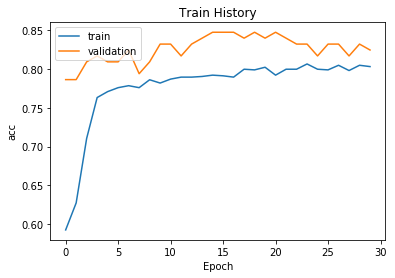

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
show_train_history(train_history,'acc','val_acc')

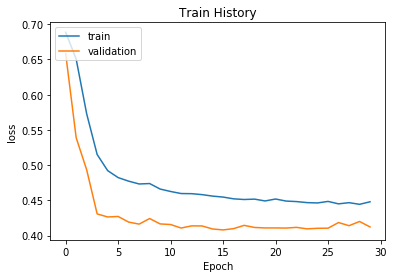

In [31]:
show_train_history(train_history,'loss','val_loss')

In [32]:
scores = model.evaluate(x=test_Features,
                        y=test_Label)
scores[1]

1309/1309 [==============================] - 0s 17us/step


0.8036669214050491

In [33]:
Jack = pd.Series([0, 'Jack', 3, 'male', 23, 1, 0, 5.0000, 'S'])
Rose = pd.Series([1, 'Rose', 1, 'female', 10, 1, 0, 100.0000, 'S'])
JR_df = pd.DataFrame([list(Jack),list(Rose)],
                   columns=['survived','name','pclass','sex',
                           'age', 'sibsp','parch','fare','embarked'])
all_df=pd.concat([all_df,JR_df])

In [35]:
all_df[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,0,Jack,3,male,23.0,1,0,5.0,S
1,1,Rose,1,female,10.0,1,0,100.0,S


In [40]:
all_Features,Label=PreprocessData(all_df)
all_probability=model.predict(all_Features)

In [41]:
all_df.insert(len(all_df.columns),'probability',all_probability)

In [42]:
all_df[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,0,Jack,3,male,23.0,1,0,5.0,S,0.134197
1,1,Rose,1,female,10.0,1,0,100.0,S,0.973519
